In [1]:
import pickle
import numpy as np
import cv2
from scipy.spatial.distance import pdist
from copy import *
from FeatureExtractor import *
from config_voting import *

# extractor = FeatureExtractor(cache_folder=model_cache_folder, which_net='alexnet', \
#                             which_layer='conv3', which_snapshot=134000)
extractor = FeatureExtractor(cache_folder=model_cache_folder, which_net='vgg16', \
                             which_layer='pool4', which_snapshot=0)

# fname='/export/home/qliu24/qing_voting_139/qing_voting_py/data/dictionary_PASCAL3D+_car_VGG16_pool4_K158_prune_512_example.pickle'
fname='/export/home/qliu24/qing_voting_139/qing_voting_py/data/SP_car_example.pickle'
with open(fname,'rb') as fh:
    example = pickle.load(fh)

N = len(example)

features = [None for nn in range(N)]

for nn in range(N):
    fnn = []
    patches = example[nn]
    for ii in range(patches.shape[1]):
        patch = patches[:,ii].reshape(100,100,3).astype('uint8')
        fnn.append(extractor.extract_feature_image(patch, is_gray=True)[0][3,3,:])
        
    features[nn] = np.array(fnn)
    
print('done')

2017-06-16 14:54:24.191843: Start Init
INFO:tensorflow:Restoring parameters from /export/home/qliu24/qing_voting_139/qing_voting_py/cache/checkpoints_vgg/vgg_16.ckpt
2017-06-16 14:54:25.584748: Finish Init
done


In [2]:
def get_stats(data):
    print('{0},{1},{2},{3}'.format(np.mean(data), np.std(data), np.min(data), np.max(data)))

In [3]:
from sklearn.manifold import TSNE
features_all = np.zeros((0,features[nn].shape[1]))
for nn in range(N):
    fnn = deepcopy(features[nn])
    f_norm = np.sqrt(np.sum(fnn**2, 1)).reshape(-1,1)
    fnn = fnn/f_norm
    features_all = np.concatenate([features_all, fnn], axis=0)
    
print(features_all.shape)

(18538, 512)


In [4]:
model = TSNE(n_components=2, random_state=0,init='pca', verbose=1)
features_all_t = model.fit_transform(features_all) 
print(features_all_t.shape)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 18538
[t-SNE] Computed conditional probabilities for sample 2000 / 18538
[t-SNE] Computed conditional probabilities for sample 3000 / 18538
[t-SNE] Computed conditional probabilities for sample 4000 / 18538
[t-SNE] Computed conditional probabilities for sample 5000 / 18538
[t-SNE] Computed conditional probabilities for sample 6000 / 18538
[t-SNE] Computed conditional probabilities for sample 7000 / 18538
[t-SNE] Computed conditional probabilities for sample 8000 / 18538
[t-SNE] Computed conditional probabilities for sample 9000 / 18538
[t-SNE] Computed conditional probabilities for sample 10000 / 18538
[t-SNE] Computed conditional probabilities for sample 11000 / 18538
[t-SNE] Computed conditional probabilities for sample 12000 / 18538
[t-SNE] Computed conditional probabilities for sample 13000 / 18538
[t-SNE] Computed conditional probabilities 

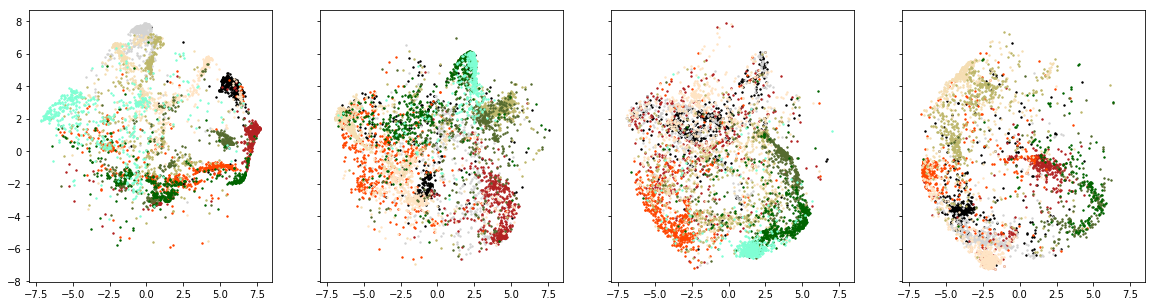

In [5]:
from matplotlib import colors as mcolors
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 5.0)

colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgba(color)[:3])), name)
                for name, color in colors.items())
sorted_names = [name for hsv, name in by_hsv]
f,ax=plt.subplots(1,4, sharex=True, sharey=True)

nn_s = 0
for nn in range(39):
    nn_i = nn%10
    nn_j = nn//10
    cnt = len(features[nn])
    fnn = features_all_t[nn_s:nn_s+cnt]
    nn_s += cnt
    ax[nn_j].scatter(fnn[:,0], fnn[:,1], s=2,color=colors[sorted_names[nn_i*10]])
    
plt.show()

In [6]:
features_2 = [None for nn in range(N)]
dis_avg = np.zeros(N)
nn_s = 0
for nn in range(N):
    cnt = len(features[nn])
    fnn = features_all_t[nn_s:nn_s+cnt]
    features_2[nn] = deepcopy(fnn)
    nn_s += cnt
    disnn = pdist(fnn)
    get_stats(disnn)
    dis_avg[nn] = np.mean(disnn)
    
get_stats(dis_avg)

1.500055439604713,1.8119738996777448,0.001062019264791452,10.20623761005275
1.7792084190680946,2.108375526889876,0.0006008364546042741,11.40245830251172
3.270442092619957,3.612640473376552,0.0006168584821019191,13.459564530298502
3.9983777026589937,2.707599065982274,0.0023077444484308754,13.619138565084436
2.879736508435482,2.0072042990772645,0.0009944167050454117,10.791077670218423
2.654145712334193,2.159625332779272,0.0007394990358054667,13.755294851239256
4.325117087233397,2.588554808580065,0.002082359497088991,12.79650945392766
3.801157367663073,2.691177892962996,0.0008371871483437486,13.485350239114917
4.362484434315902,2.9583915639382328,0.0028722471795855327,13.85646836269644
4.234642226297667,2.562312598476748,0.006206154134725504,13.796679409083334
3.5454490053942336,2.805391815784224,0.0010223159511804523,14.545508235117543
4.548513901344708,2.48590782744111,0.003378117556054683,13.716530045481994
2.5670548794992945,1.7904202912840403,0.003438497837974501,11.75932209189314
3.

In [8]:
for rr in range(10):
    fnn_r = np.zeros((0,features_2[0].shape[1]))
    for nn in range(N):
        fnn = features_2[nn]
        fnn_r = np.concatenate((fnn_r, fnn[np.random.choice(fnn.shape[0], size=(10,), replace=False), :]), axis=0)
        
    get_stats(pdist(np.array(fnn_r)[np.random.choice(N*10, size=(200,), replace=False)]))

6.440848630610769,3.053843548356433,0.03201531229715851,14.147925712311
6.481384932665679,3.0386555421855106,0.015266578562645294,14.551582328426223
6.444148994331172,3.0282608512554505,0.04340628376536481,14.277466183517305
6.37755224714693,3.005742751092751,0.012851490675681638,14.963627358464448
6.687455161688428,3.118935609664238,0.03189794011552884,15.088875364684363
6.4891124772387245,3.0451043664686708,0.030296189462280396,14.851250531229567
6.460277497212011,3.083376345036693,0.01976177592582609,14.50355350346416
6.634948290964745,3.1077729072130507,0.028186025217130123,14.912179917337578
6.522110654828744,3.064406900001956,0.05031857693738419,15.095970631526308
6.537554759316402,3.0508652105981406,0.017024478447767416,14.699479189697316


In [3]:
dis_avg = np.zeros(N)
for nn in range(N):
    fnn = deepcopy(features[nn])
    f_norm = np.sqrt(np.sum(fnn**2, 1)).reshape(-1,1)
    fnn = fnn/f_norm
    # print(fnn.shape)
    disnn = pdist(fnn)
    # print(disnn.shape)
    get_stats(disnn)
    dis_avg[nn] = np.mean(disnn)
    
get_stats(dis_avg)

0.666556850336252,0.1450406755487457,0.14250406829697282,1.1875215524200076
0.6800125159627854,0.1308482724694822,0.17724886426961023,1.13517981107781
0.671682106349027,0.1650003482778063,0.10431544513320871,1.1854914153722826
0.6624482562837981,0.1353433762135755,0.15547718117472176,1.197599604368476
0.646746971065196,0.12922296874358455,0.15559343023248143,1.0747519666653358
0.6805051098405644,0.1270307681999244,0.2162407547706488,1.2040895827780207
0.6910542705656761,0.13984953957064294,0.2039527843519758,1.1857530829489906
0.6496795419940146,0.13181045387915113,0.1954992674144903,1.1266338245827077
0.6476695804354377,0.1336967584055837,0.16490442188240834,1.089627624847736
0.6380084676670811,0.14421083594677855,0.0,1.1621950760692656
0.6413591152217802,0.1424810533855496,0.12060065762655169,1.1799769377233087
0.6851252472047261,0.12270292103139499,0.17475510020744767,1.181194228522004
0.6861221645146836,0.12371100550307502,0.1956895046001647,1.0925093267522477
0.6627539922980249,0.

In [4]:
for rr in range(10):
    fnn_r = np.zeros((0,features[0].shape[1]))
    for nn in range(N):
        fnn = deepcopy(features[nn])
        f_norm = np.sqrt(np.sum(fnn**2, 1)).reshape(-1,1)
        fnn = fnn/f_norm
        fnn_r = np.concatenate((fnn_r, fnn[np.random.choice(fnn.shape[0], size=(10,), replace=False), :]), axis=0)

    get_stats(pdist(np.array(fnn_r)[np.random.choice(N*10, size=(200,), replace=False)]))

0.7425726736345026,0.1307298434306324,0.25550403450070774,1.165897147339565
0.7611632702188453,0.13534062364548133,0.2526165123728579,1.1851271067467901
0.7403371410700951,0.13461028979589612,0.2708640454492077,1.1642848945337803
0.7456006726730503,0.13670580902658888,0.2590160457421969,1.2515717757492988
0.7484748263812049,0.1420872282025385,0.20904189742254287,1.2642743382342085
0.7361888924104465,0.12725195180540314,0.2864083481590164,1.1897082294274368
0.7422248604368198,0.1409494476850515,0.24092899465663817,1.2037475993796165
0.748969951494759,0.13573585954426823,0.255475369805174,1.2622451812496718
0.7649401769299254,0.13725082111294193,0.2639560009088587,1.2206267690807413
0.7560702197442607,0.13000188470449028,0.21240245709323605,1.1694432026640091


In [7]:
from config_voting import *
from scipy.spatial.distance import pdist

cluster_file = '/export/home/qliu24/qing_voting_139/qing_voting_py/data/dictionary_PASCAL3D+_car_VGG16_pool4_K158_prune_512.pickle'

print('loading data...')

# number of files to read in
file_num = 1
feat_set = np.zeros((featDim, 0))
loc_set = np.zeros((5, 0), dtype='int')
img_set = []
for ii in range(file_num):
    print('loading file {0}/{1}'.format(ii+1, file_num))
    # fname = Dict['cache_path']+str(ii)+'.pickle'
    fname = '/export/home/qliu24/qing_voting_139/qing_voting_py/data/pool4_all_dumped_data0.pickle'
    with open(fname, 'rb') as fh:
        res, iloc, iimg = pickle.load(fh)
        feat_set = np.column_stack((feat_set, res))
        loc_set = np.column_stack((loc_set, iloc.astype('int')))
        img_set += iimg
        
print('all feat_set')
print(feat_set.shape)
print('all loc_set')
print(loc_set.shape)
print('all images')
print(len(img_set))

with open(cluster_file, 'rb') as fh:
    assignment, centers = pickle.load(fh)
    
    
K = centers.shape[0]

feat_norm = np.sqrt(np.sum(feat_set**2, 0))
feat_set = feat_set/feat_norm

# the num of images for each cluster
num = 200
dis_all = []
for k in range(K):
    target = centers[k]
    index = np.where(assignment == k)[0]
    num = min(num, len(index))
    
    tempFeat = feat_set[:,index]
    error = np.sum((tempFeat.T - target)**2, 1)
    sort_idx = np.argsort(error)
    fnn = feat_set[:,index[sort_idx[0:num]]].T
    disnn = pdist(fnn)
    dis_all.append(np.mean(disnn))
    
print(np.mean(dis_all))
    

loading data...
loading file 1/1
all feat_set
(512, 100000)
all loc_set
(5, 100000)
all images
1000
0.992587420879


In [8]:
fnn = feat_set[:,np.random.choice(feat_set.shape[1],size=(num,))].T
disnn = pdist(fnn)
print(np.mean(disnn))

1.2892404784


In [5]:
from config_voting import *
import scipy.io as sio

category='car'
dir_anno = Dataset['anno_dir'].format(category)
dir_img = Dataset['img_dir'].format(category)
sp_dir = SP['anno_dir'].format(category)
file_list = SP['img_list'].format(category)
assert(os.path.isfile(file_list))
with open(file_list, 'r') as fh:
    content = fh.readlines()

img_list = [x.strip().split() for x in content]
img_num = len(img_list)
print('total number of images for {1}: {0}'.format(img_num, category))
res_info = [dict() for ii in range(img_num)]


total number of images for car: 2000


In [60]:
SPnum = 39
SP_patch = [[] for kk in range(SPnum)]
for ii in range(img_num):
    imgPath = os.path.join(dir_img, '{0}.JPEG'.format(img_list[ii][0]))
    annoPath = os.path.join(dir_anno, '{0}.mat'.format(img_list[ii][0]))
    spPath = os.path.join(sp_dir, '{0}.mat'.format(img_list[ii][0]))

    assert(os.path.isfile(spPath))
    mat_contents = sio.loadmat(spPath)
    spanno = mat_contents['anno'][int(img_list[ii][1])-1, 1]

    assert(os.path.isfile(imgPath))
    img = cv2.imread(imgPath)
    height, width = img.shape[0:2]

    assert(os.path.isfile(annoPath))
    mat_contents = sio.loadmat(annoPath)
    record = mat_contents['record']
    objects = record['objects']
    bbox = objects[0,0]['bbox'][0,int(img_list[ii][1])-1][0]
    bbox = [max(math.ceil(bbox[0]), 1), max(math.ceil(bbox[1]), 1), \
            min(math.floor(bbox[2]), width), min(math.floor(bbox[3]), height)]

    patch = img[bbox[1]-1: bbox[3], bbox[0]-1: bbox[2], :]
    scalePatch = myresize(patch, 224, 'short')
    pheight, pwidth = scalePatch.shape[0:2]
    
    for kk in range(SPnum):
        inst = spanno[kk, 0]
        for jj in range(inst.shape[0]):
            sp_bbox = [max(math.ceil(inst[jj,0]), 1), max(math.ceil(inst[jj,1]), 1), \
                       min(math.floor(inst[jj,2]), pwidth), min(math.floor(inst[jj,3]), pheight)]
                    
            SP_patch[kk].append(scalePatch[sp_bbox[1]-1:sp_bbox[3], sp_bbox[0]-1:sp_bbox[2]])
            
    if ii%20==0:
        print(ii, end=' ', flush=True)
        
print('')

0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340 360 380 400 420 440 460 480 500 520 540 560 580 600 620 640 660 680 700 720 740 760 780 800 820 840 860 880 900 920 940 960 980 1000 1020 1040 1060 1080 1100 1120 1140 1160 1180 1200 1220 1240 1260 1280 1300 1320 1340 1360 1380 1400 1420 1440 1460 1480 1500 1520 1540 1560 1580 1600 1620 1640 1660 1680 1700 1720 1740 1760 1780 1800 1820 1840 1860 1880 1900 1920 1940 1960 1980 


In [62]:
np.max([len(xx) for xx in SP_patch])

3231

In [78]:
examples = [None for kk in range(SPnum)]
for kk in range(SPnum):
    num = min(500, len(SP_patch[kk]))
    rst = np.zeros((num, 100*100*3)).astype('uint8')
    for pp in range(num):
        patch = SP_patch[kk][pp]
        # print(patch.shape)
        phh,pww = patch.shape[0:2]
        if pww>100 or phh>100:
            print(phh,pww)
            patch = patch[0:100,0:100,:]
            phh,pww = patch.shape[0:2]
        
        diff_w1=0
        diff_w2=0
        diff_h1=0
        diff_h2=0
        if pww<100:
            diff_w1 = int((100-pww)/2)
            diff_w2 = int(100-pww-diff_w1)
        
        if phh<100:
            diff_h1 = int((100-phh)/2)
            diff_h2 = int(100-phh-diff_h1)
        
        patch_p = np.pad(patch, ((diff_h1, diff_h2),(diff_w1, diff_w2),(0,0)), 'constant', constant_values=0)
        # print(patch_p.shape)
        assert(patch_p.shape==(100,100,3))
        rst[pp,:] = patch_p.flatten()
        
    examples[kk] = deepcopy(rst).T
    
        

101 100
101 101
101 100
64 101
61 101
100 101
100 101
101 101
100 101
98 101
101 100
64 101
100 101
100 101
101 100
100 101
100 101
81 101
100 101
100 101
101 101
100 101
101 101
100 101
101 101
100 101
101 100
100 101


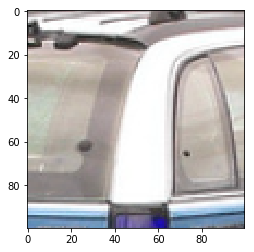

In [80]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(examples[38][:,40].reshape(100,100,3))
plt.show()



In [81]:
import pickle
fnm = '/export/home/qliu24/qing_voting_139/qing_voting_py/data/SP_car_example.pickle'
with open(fnm, 'wb') as fh:
    pickle.dump(examples, fh)